In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import collections
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor

# With this notebook ı will build very basic regression models. But scores will increase with very basic tricks. You can add more complex algorithm to reach more high scores
# such as ;
* Stacking Algorithm,
* Feature Engineering.
* more complex models
* deep statistical.

In [14]:
data = pd.read_csv("prices.csv")
temp = data.head(3)
temp.style.background_gradient(cmap="Oranges")

,price,lot_area,living_area,num_floors,num_bedrooms,num_bathrooms,waterfront,year_built,year_renovated
0,221900,5650,1180,1.000000,3,1.000000,0,1955,0
1,538000,7242,2570,2.000000,3,2.250000,0,1951,1991
2,180000,10000,770,1.000000,2,1.000000,0,1933,0


# Tricks 1 "Missing value operations"
* But for this dataset we have not any missing value.

In [15]:
print(data.info(3))
temp = data.describe()
temp.style.background_gradient(cmap="ocean_r")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           21613 non-null  int64  
 1   lot_area        21613 non-null  int64  
 2   living_area     21613 non-null  int64  
 3   num_floors      21613 non-null  float64
 4   num_bedrooms    21613 non-null  int64  
 5   num_bathrooms   21613 non-null  float64
 6   waterfront      21613 non-null  int64  
 7   year_built      21613 non-null  int64  
 8   year_renovated  21613 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.5 MB
None


,price,lot_area,living_area,num_floors,num_bedrooms,num_bathrooms,waterfront,year_built,year_renovated
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,540088.141767,15106.967566,2079.899736,1.494309,3.370842,2.114757,0.007542,1971.005136,84.402258
std,367127.196483,41420.511515,918.440897,0.539989,0.930062,0.770163,0.086517,29.373411,401.679240
min,75000.000000,520.000000,290.000000,1.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,321950.000000,5040.000000,1427.000000,1.000000,3.000000,1.750000,0.000000,1951.000000,0.000000
50%,450000.000000,7618.000000,1910.000000,1.500000,3.000000,2.250000,0.000000,1975.000000,0.000000
75%,645000.000000,10688.000000,2550.000000,2.000000,4.000000,2.500000,0.000000,1997.000000,0.000000
max,7700000.000000,1651359.000000,13540.000000,3.500000,33.000000,8.000000,1.000000,2015.000000,2015.000000


In [16]:
X = data.drop(["price"],axis=1)
y = data["price"]

# Tricks 2 "Transformation"

* for a good regression models we have some assumptions like normality.
* You can see the saleprice distributions. This is not a normal distribution. Make it normal.
* You can use some transformations methods which are log, box cox and Arcsine transformation. (the link is in the references block)
* You can check this proses with visualization and skewness, kurtosis values

In [17]:
y_1 = np.log(y)  # Price columns 

AttributeError: module 'seaborn' has no attribute 'histplot'

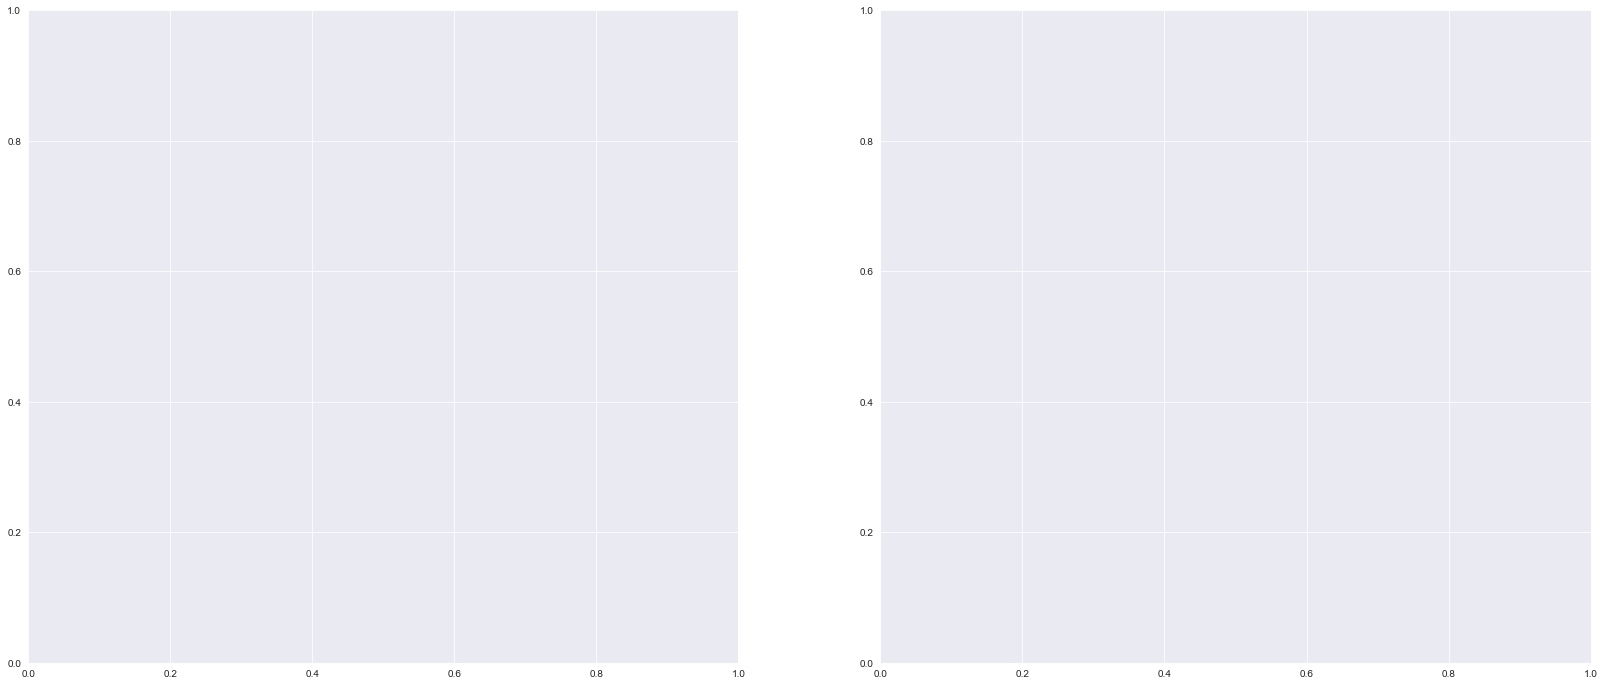

In [12]:
sns.set_style("darkgrid")
fig, axarr = plt.subplots(1, 2, figsize=(28,12))
sns.histplot(data["price"], bins=100,kde=True,ax=axarr[0])
axarr[0].set_title("Price Distribution", color="#f60000", size=20)
axarr[0].set_ylabel('Count', fontsize = 20, color="#2d242e")
axarr[0].set_xlabel('Price', fontsize = 20, color="#2d242e")


sns.histplot(y_1, bins=80, kde=True, ax=axarr[1])
axarr[1].set_title("Price distribution after log transformation", color="#f60000", size=20)
axarr[1].set_ylabel('Count', fontsize = 20, color="#2d242e")
axarr[1].set_xlabel('Log_price', fontsize = 20, color="#2d242e")
fig.show()

In [18]:
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())
print("*"*50)
print("Skewness after log transformation: %f" % y_1.skew())
print("Kurtosis after log transformation: %f" % y_1.kurt())

Skewness: 4.024069
Kurtosis: 34.585540
**************************************************
Skewness after log transformation: 0.428072
Kurtosis after log transformation: 0.691854


# Trick 3 "Observe the data with statistical values and different type of visualizations"

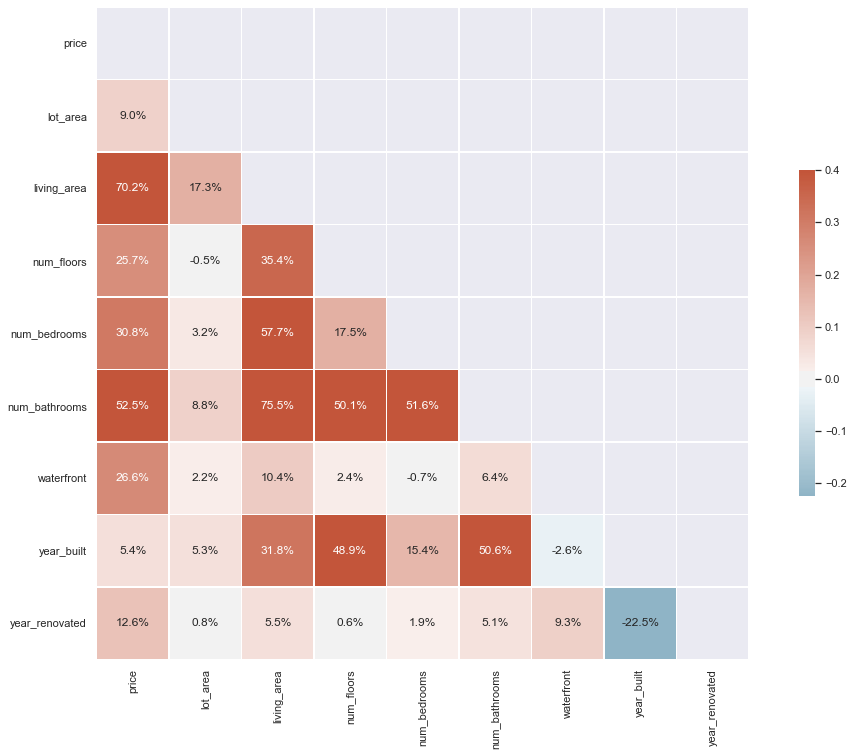

In [19]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set(style="dark")
f, ax = plt.subplots(figsize=(18, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5}, annot=True ,fmt='.1%')

<Figure size 720x720 with 0 Axes>

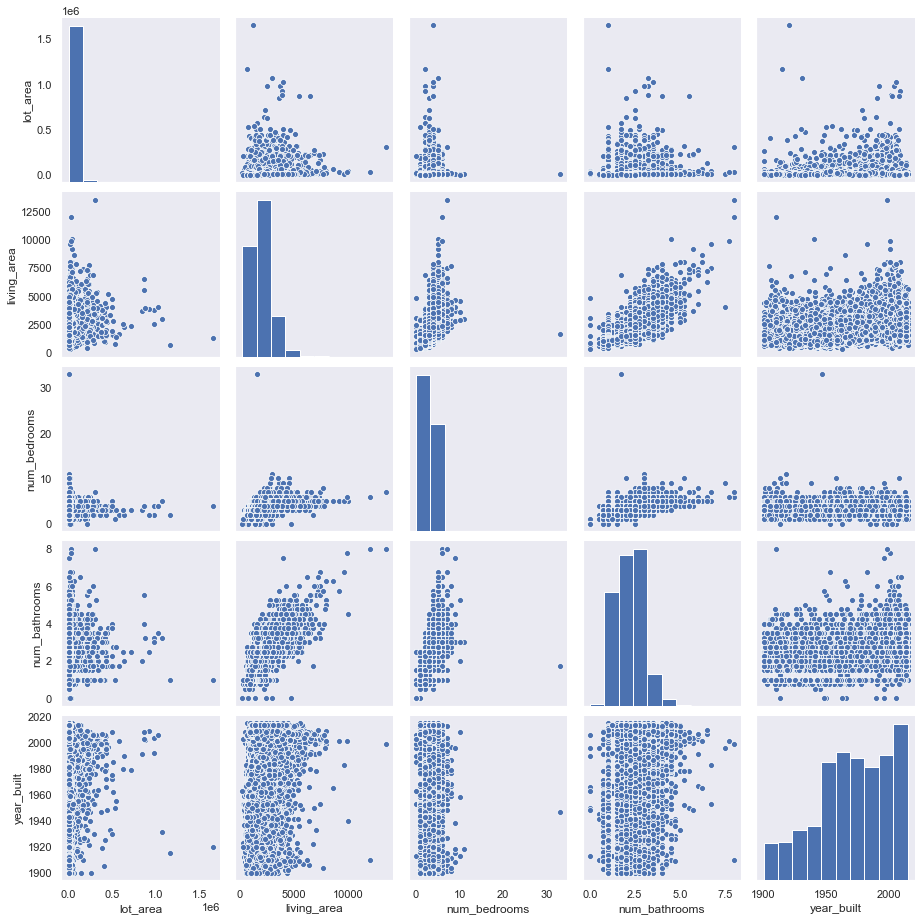

In [21]:
plt.figure(figsize=(10,10))
cols = ['lot_area', 'living_area', 'num_bedrooms', 'num_bathrooms', 
        'year_built']
sns.pairplot(data[cols], height = 2.5)
plt.savefig("squares.png")
plt.show();

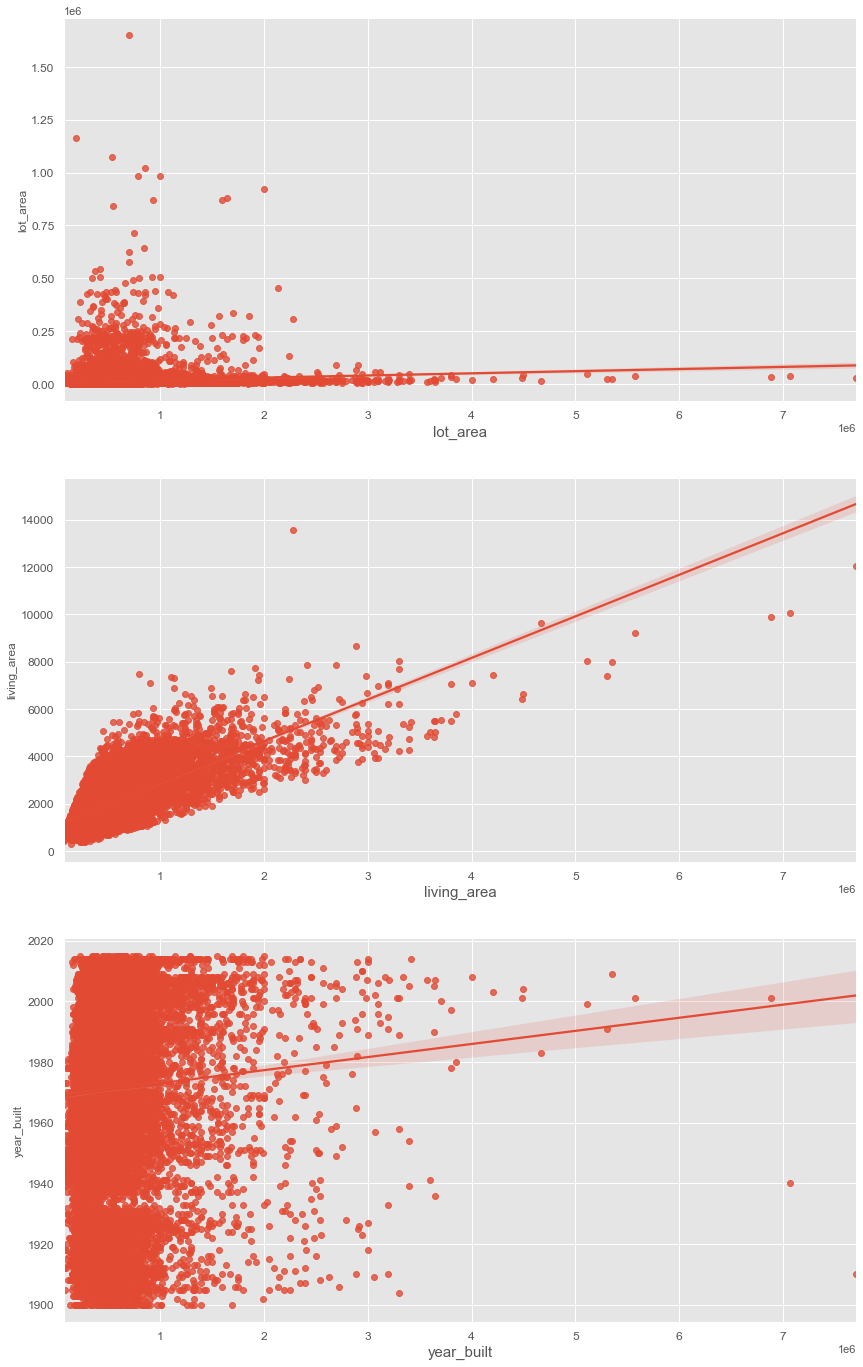

In [22]:
col = ['lot_area', 'living_area', 'year_built']
plt.style.use("ggplot")
fig, axs = plt.subplots(ncols = 1, nrows = 3, figsize=(8,24))
plt.subplots_adjust(right=1.5)
for i, feature in enumerate(col, 1):
    plt.subplot(3,1,i)
    sns.regplot(x = "price", y= feature, data = data)
    plt.xlabel('{}'.format(feature), size=15)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
plt.show()

# Tricks 4 "Find outlier and handle."

* We want to use outliers for some projects like spam detect, fraud detection or disease diagnosis. But this case we dont want it.
* regression models is very sensetive the outliers.
* For this data outliers reduce the our scores.

# Tricks 5 "IQR * "X" "

* x can be 1.5 or 3 generally. But for large ranges it makes more sense to use 3.
* In this case (IQR 1.5) find "470" row. But with (IQR 3) we find only "82" row. This differences affects the score a lot.

In [24]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        #1st quartile
        Q1=np.percentile(df[c],25)
        #3st quartile
        Q3=np.percentile(df[c],75)
        #IQR 
        IQR=Q3-Q1
        #outlier step
        outlier_step=IQR*1.5
        #detect outlier
        outlier_list_col=df[(df[c] < Q1-outlier_step) | (df[c] > Q3 + outlier_step)].index
        #store indeces
        outlier_indices.extend(outlier_list_col)
    outlier_indices = collections.Counter(outlier_indices)
    multiple_outliers = list(i for i , v in outlier_indices.items() if v > 2)
        
    return multiple_outliers

outliers_index = detect_outliers(data,['price', 'lot_area', 'living_area', 'num_floors', 'num_bedrooms',
       'num_bathrooms', 'waterfront', 'year_built', 'year_renovated'])
print(len(outliers_index))

470


In [25]:
data = data.drop(outliers_index)
data = pd.DataFrame(data)

X = data.drop(["price"],axis=1)
y = np.log(data["price"])

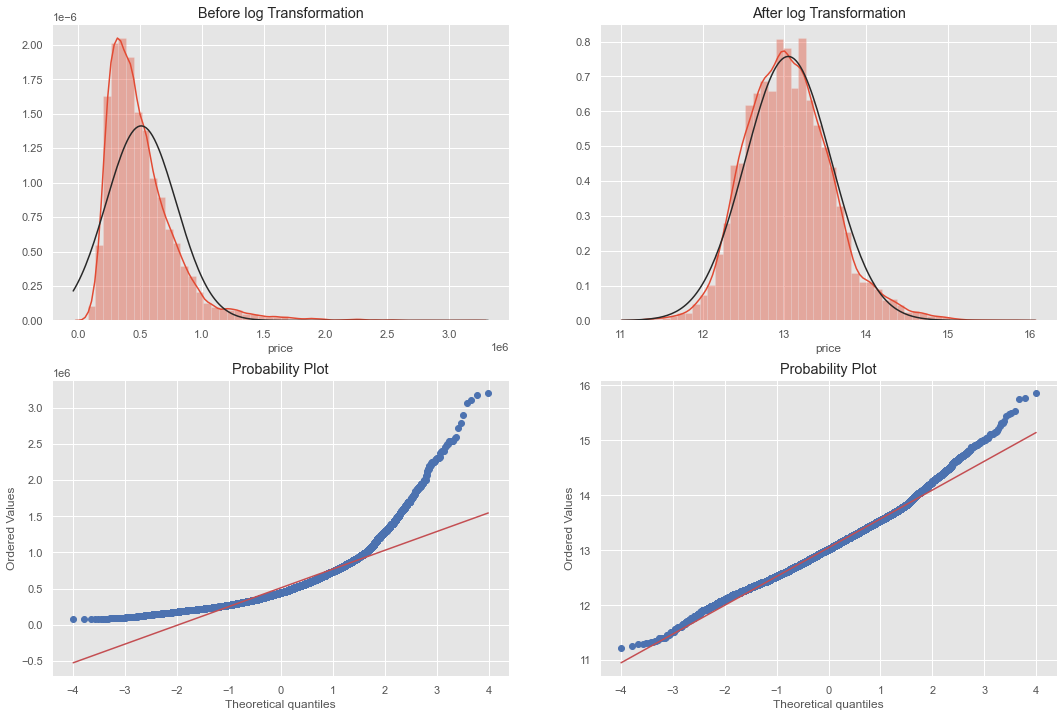

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
ax[0,0].set_title("Before log Transformation")
sns.distplot(data["price"], fit=norm, ax= ax[0,0])
stats.probplot(data["price"], plot=ax[1,0])

ax[0,1].set_title("After log Transformation")
sns.distplot(y_1, fit=norm, ax= ax[0,1])
stats.probplot(y_1, plot=ax[1,1])
plt.show()

# Trick 6 "Use cross validation"

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=4)
n_folds = 5

"""root-mean-square error (RMSE) is a frequently used measure of the differences between 
values (sample or population values) predicted by a model or an estimator and the values observed. """

def rmsle_cv(model):
    kfold  = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kfold))
    return(rmse)

# Trick 7 "Parameters optimization"

* Models need to be optimized. You can increase your score effectively with this way.

In [33]:
"""
#Lasso
grid_lasso={'alpha' : [0.05,0.005, 0.0005, 0.00005],
            'max_iter': [100,500,1000]}
lasso=Lasso()
lasso_cv=GridSearchCV(lasso, grid_lasso, cv=5)
lasso_cv.fit(X_train,y_train)
print("best hpyerparameters :",lasso_cv.best_params_)
print("Score :",lasso_cv.best_score_)

#Enet
grid_enet={'alpha' : [0.05,0.005, 0.0005, 0.00005],
          'l1_ratio': np.linspace(0.1,0.9, 8)}
enet=ElasticNet()
enet_cv=GridSearchCV(enet, grid_enet, cv=5)
enet_cv.fit(X_train,y_train)
print("best hpyerparameters :",enet_cv.best_params_)
print("Score :",enet_cv.best_score_)

#XGBregressor
grid_xgb={'reg_lambda' : np.linspace(0.1,1,9),
          'reg_alpha' :  np.linspace(0.1,0.6,10),
          'min_child_weight' : np.linspace(1,4,9),
          'gamma' : np.linspace(0.01,1,10),
          'subsample':[0.3,0.4,0.5]}
xgb=XGBRegressor()
xgb_cv=GridSearchCV(xgb, grid_xgb, cv=5)
xgb_cv.fit(X_train,y_train)
print("best hpyerparameters :",xgb_cv.best_params_)
print("Score :",xgb_cv.best_score_)
"""

'\n#Lasso\ngrid_lasso={\'alpha\' : [0.05,0.005, 0.0005, 0.00005],\n            \'max_iter\': [100,500,1000]}\nlasso=Lasso()\nlasso_cv=GridSearchCV(lasso, grid_lasso, cv=5)\nlasso_cv.fit(X_train,y_train)\nprint("best hpyerparameters :",lasso_cv.best_params_)\nprint("Score :",lasso_cv.best_score_)\n\n#Enet\ngrid_enet={\'alpha\' : [0.05,0.005, 0.0005, 0.00005],\n          \'l1_ratio\': np.linspace(0.1,0.9, 8)}\nenet=ElasticNet()\nenet_cv=GridSearchCV(enet, grid_enet, cv=5)\nenet_cv.fit(X_train,y_train)\nprint("best hpyerparameters :",enet_cv.best_params_)\nprint("Score :",enet_cv.best_score_)\n\n#XGBregressor\ngrid_xgb={\'reg_lambda\' : np.linspace(0.1,1,9),\n          \'reg_alpha\' :  np.linspace(0.1,0.6,10),\n          \'min_child_weight\' : np.linspace(1,4,9),\n          \'gamma\' : np.linspace(0.01,1,10),\n          \'subsample\':[0.3,0.4,0.5]}\nxgb=XGBRegressor()\nxgb_cv=GridSearchCV(xgb, grid_xgb, cv=5)\nxgb_cv.fit(X_train,y_train)\nprint("best hpyerparameters :",xgb_cv.best_params_

# Trick 8 "Scaler type""

* There are many different scaler algorithm. You can implement the best scaler method according your data. For example;
* Robust Scaler works similarly to Normalization. It may give better results on data with outliers.
* StandardScaler removes the mean and scales the data to unit variance. However, the outliers have an
influence when computing the empirical mean and standard deviation which shrink the range of the feature values.
StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

In [34]:
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0005,
                                              max_iter =100,
                                              random_state=1))

ENet = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005,
                                                  l1_ratio=0.1,
                                                  random_state=1))

model_xgb = XGBRegressor(gamma=0.045, 
                         learning_rate=0.05, max_depth=3, 
                         min_child_weight=1.7, n_estimators=2000,
                         reg_alpha=0.4, reg_lambda=0.8,
                         subsample=0.5,
                         random_state =1)

lin_reg = make_pipeline(StandardScaler(), LinearRegression())

In [35]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.6f} (rmse) \n".format(score.mean()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.5f} (rmse) \n".format(score.mean()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.6f} (rmse) \n".format(score.mean()))

score = rmsle_cv(lin_reg)
print("Lineer Reg. score: {:.6f} (rmse) \n".format(score.mean()))


Lasso score: 0.349099 (rmse) 

ElasticNet score: 0.34910 (rmse) 

Xgboost score: 0.325088 (rmse) 

Lineer Reg. score: 0.349104 (rmse) 



In [36]:
from datetime import datetime
K = 5
kfold = KFold(n_splits=K, shuffle=True, random_state=1)

In [37]:
models = {'LassoCV': lasso, 
          'ElasticNetCV': ENet,
          'XGBoostRegressor': model_xgb,
          'LineerRegression': lin_reg}

predictions = {}
scores = {}
def cv_rmse(model, X=X_train, y=y_train):    
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold))

for name, model in models.items():
    
    model.fit(X_train, y_train)
    predictions[name] = np.expm1(model.predict(X_test))
    
    score = cv_rmse(model, X=X_test, y=y_test)
    scores[name] = (score.mean(), score.std())
    
    print(' {} Mean RMSE: {:.6f} / Std: {:.6f}\n'.format(name, scores[name][0], scores[name][1]))

 LassoCV Mean RMSE: 0.352797 / Std: 0.006432

 ElasticNetCV Mean RMSE: 0.352837 / Std: 0.006514

 XGBoostRegressor Mean RMSE: 0.341628 / Std: 0.006346

 LineerRegression Mean RMSE: 0.352849 / Std: 0.006536



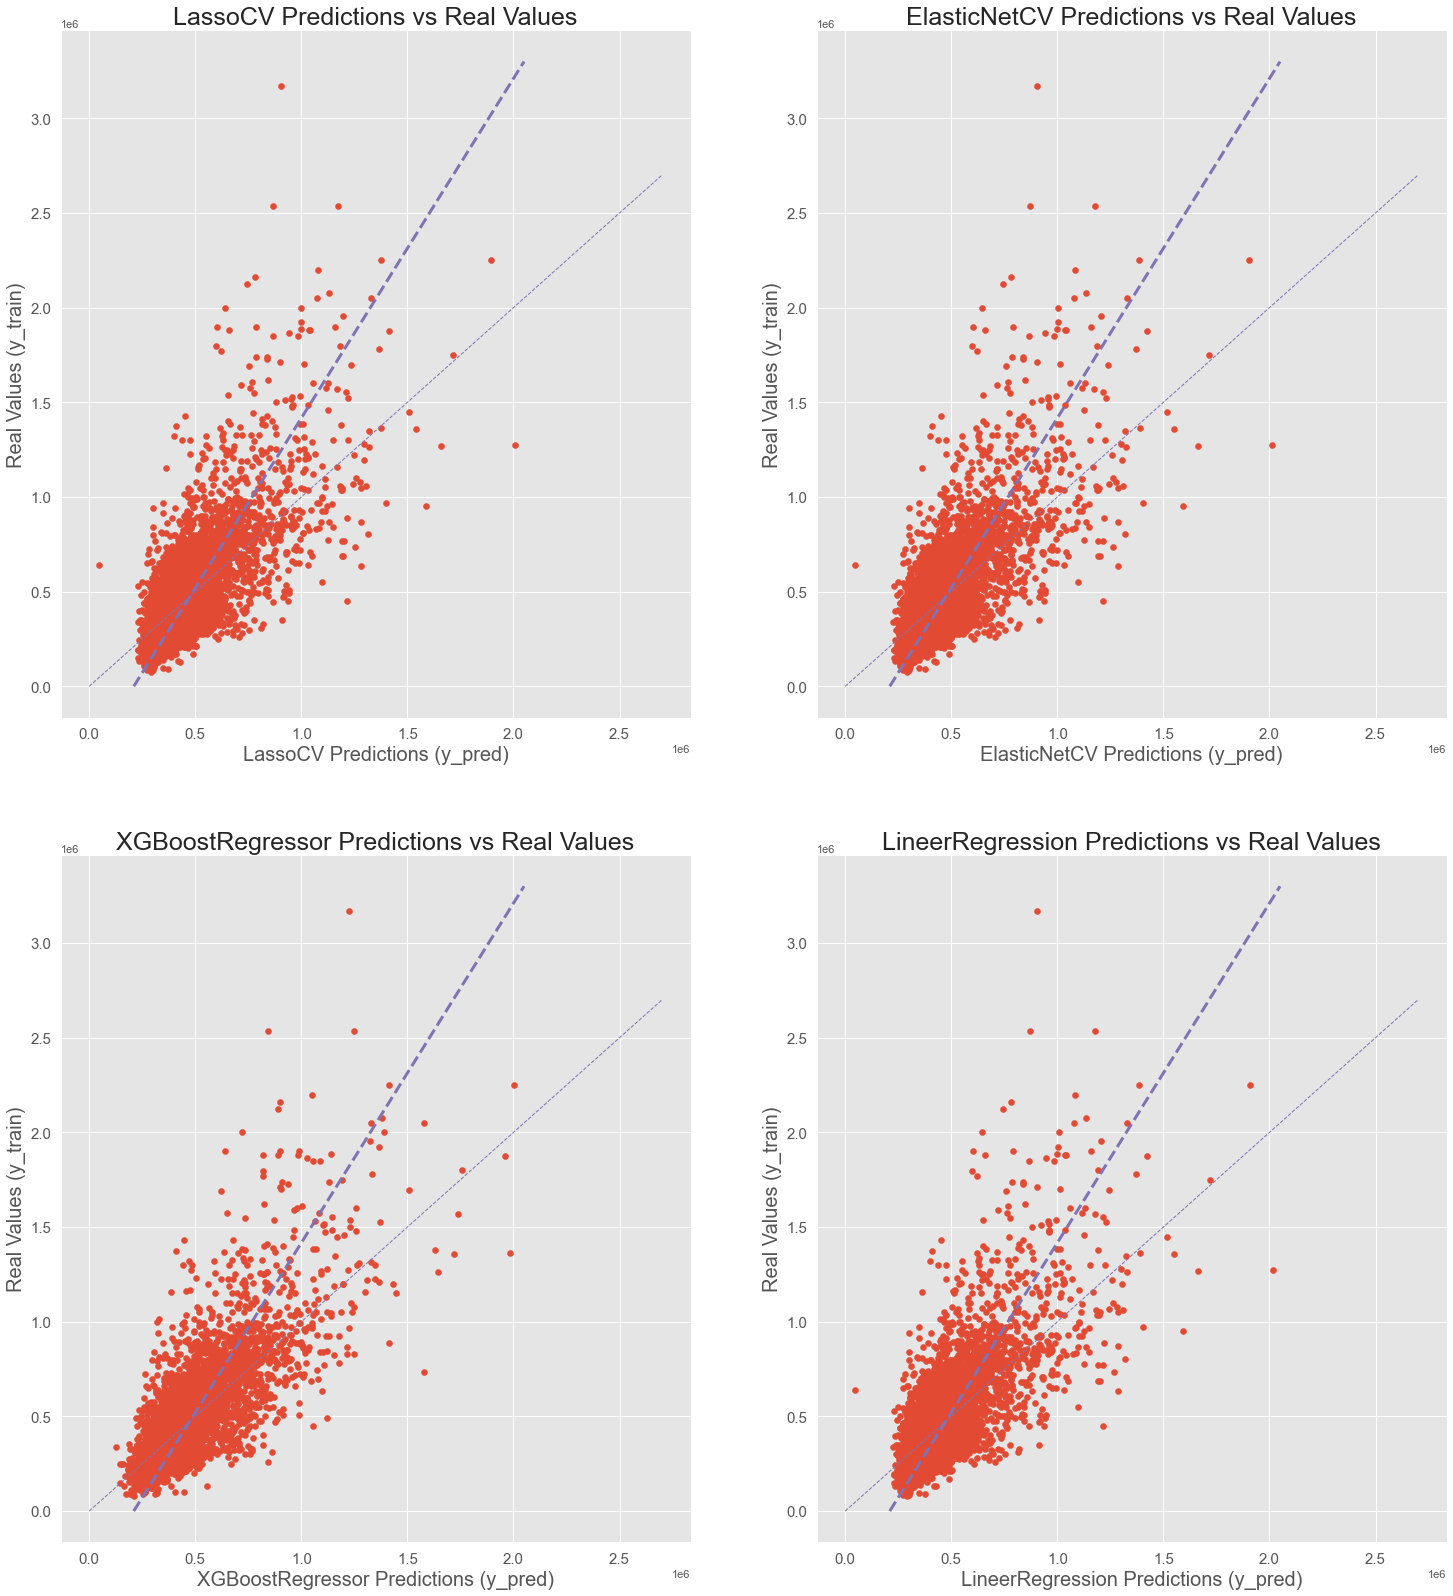

In [38]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 24))
plt.subplots_adjust(top=1, right=1.5)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    plt.scatter(predictions[model], np.expm1(y_test))
    plt.plot([210000, 2050000], [0, 3300000], '--m', linewidth=3)
    plt.plot([0, 2700000], [0, 2700000], '--m', linewidth=1)
    

    plt.xlabel('{} Predictions (y_pred)'.format(model), size=20)
    plt.ylabel('Real Values (y_train)', size=20)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('{} Predictions vs Real Values'.format(model), size=25)

plt.show()

# Trick 9 "Blend the models"

* Many times all models predict same value for some parts. But complicated part can be different
for each model when models predictions are blended, models can work more effective

In [39]:
def blend_predict(X):
    return ((0.2  * ENet.predict(X)) + 
            (0.2 * lasso.predict(X)) +
            (0.5 * model_xgb.predict(X)) +
            (0.1  * lin_reg.predict(X)))

blended_score = rmse(y_train, blend_predict(X_train))
print('Blended RMSE: {}'.format(blended_score))

Blended RMSE: 0.09813889514506721


# compare the models scores

In [40]:
df = pd.DataFrame({'Regression Models': ["lasso", "Elastic_net", "Xgboost","LineerRegression"],
                   'Raw Scores':[0.5230, 0.5250, 0.37537, 0.5423],
                   'After Optimizations': [0.349099,0.34910 ,0.341628, 0.352849],
                   'With Blend Method':[0.098138,0.098138,0.098138,0.098138]})

detas = df.set_index('Regression Models')
detas.style.background_gradient(cmap="Oranges")

,Raw Scores,After Optimizations,With Blend Method
Regression Models,,,
lasso,0.523000,0.349099,0.098138
Elastic_net,0.525000,0.349100,0.098138
Xgboost,0.375370,0.341628,0.098138
LineerRegression,0.542300,0.352849,0.098138
